In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# Here usually we have a db connection defined with a parametrized query that runs daily agains the DB
# Reading from csv instead for simplicity
backfill = pd.read_csv('data.csv')
print(backfill.shape)
print(backfill.info())
print(backfill.head())


(100000, 147)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 147 entries, PLATFORM to PLATFORM.1
dtypes: float64(82), int64(57), object(8)
memory usage: 112.2+ MB
None
      PLATFORM PREDICTING_DATE  PLATFORM_GP  PLATFORM_IOS  \
0      Windows      2021-02-20            0             0   
1  Google Play      2021-02-20            1             0   
2      Windows      2021-02-20            0             0   
3          iOS      2021-02-20            0             1   
4      Windows      2021-02-20            0             0   

               INSTALL_TIME INSTALL_DATE  INSTALL_HR  INSTALL_DOW  COUNTRY_US  \
0  2016-04-06T16:58:00.000Z   2016-04-06          16            3           0   
1  2020-03-25T05:45:45.000Z   2020-03-25           5            3           0   
2  2018-12-07T17:35:19.000Z   2018-12-07          17            5           0   
3  2019-09-29T18:37:14.000Z   2019-09-29          18            0           0   
4  2019-05-09T12:19:1

In [3]:
target_name = 'IS_CHURN'
feature_names = [
    'PLATFORM_GP', 'PLATFORM_IOS', 'INSTALL_HR', 'INSTALL_DOW',
       'COUNTRY_US', 'COUNTRY_CA', 'COUNTRY_CN', 'COUNTRY_ID',
       'COUNTRY_BR', 'COUNTRY_KR', 'COUNTRY_JP', 'COUNTRY_RU',
       'COUNTRY_DE', 'COUNTRY_FR', 'COUNTRY_GB', 'COUNTRY_AT',
       'COUNTRY_IT', 'COUNTRY_ES', 'COUNTRY_VN', 'COUNTRY_IN',
       'COUNTRY_TR', 'COUNTRY_MX', 'COUNTRY_TH', 'COUNTRY_UA',
       'COUNTRY_PH', 'COUNTRY_MY', 'COUNTRY_EG', 'DEVICE_IPHONE',
       'DEVICE_IPHONE_LAST', 'DEVICE_IPAD', 'DEVICE_IPAD_LAST',
       'DEVICE_SAMSUNG', 'MIN_GAP_INSTALL_TS', 'MAX_GAP_INSTALL_TS',
       'MAX_TIME_SPENT', 'SUM_TIME_SPENT', 'TIME_SPENT_1ST',
       'TIME_SPENT_LAST', 'TIME_SPENT_2NDLAST', 'MAX_BTW_SESS',
       'SUM_BTW_SESS', 'BTW_SESS_1ST', 'BTW_SESS_LAST',
       'BTW_SESS_2NDLAST', 'TOTAL_RESUMES', 'TOTAL_LAUNCHS',
       'TOTAL_FIRST_LAUNCHS', 'TOTAL_CRASH', 'CNT_LAUNCHES',
       'CNT_LAUNCHES_T900', 'CNT_LAUNCHES_T600', 'CNT_LAUNCHES_T300',
       'CNT_LAUNCHES_T60', 'CNT_LAUNCHES_T180',
       'CNT_TIME_BETWEEN_SESSIONS_T240', 'CNT_TIME_BETWEEN_SESSIONS_T480',
       'CNT_TIME_BETWEEN_SESSIONS_T720',
       'CNT_TIME_BETWEEN_SESSIONS_T1440', 'ACTIVE_DOW', 'MAX_NB_SESSIONS',
       'SUM_NB_SESSIONS', 'NB_SESSIONS_LAST', 'NB_SESSIONS_1ST',
       'MAX_ACT_TIME_SPENT', 'SUM_ACT_TIME_SPENT', 'IS_ACT_CC_SAME',
       'IS_PAU_TO_DATE', 'REV_TO_DATE', 'MAX_REV_TODAY', 'TRANS_TO_DATE',
       'MAX_TRANS_TODAY', 'CNT_ACT_PLATFORM', 'CNT_ACT_RECORDS',
       'IS_ACTIVE_N_1', 'IS_ACTIVE_N_2', 'IS_ACTIVE_N_3',
       'IS_ACTIVE_N_4', 'IS_ACTIVE_N_5', 'IS_ACTIVE_N_6', 'IS_ACTIVE_N_7',
       'TIME_SPENT_D7', 'TIME_SPENT_D6', 'TIME_SPENT_D5', 'TIME_SPENT_D4',
       'TIME_SPENT_D3', 'TIME_SPENT_D2', 'TIME_SPENT_D1',
       'NB_SESSIONS_D7', 'NB_SESSIONS_D6', 'NB_SESSIONS_D5',
       'NB_SESSIONS_D4', 'NB_SESSIONS_D3', 'NB_SESSIONS_D2',
       'NB_SESSIONS_D1', 'MIN_PROGRESS_INDEX01', 'MEAN_PROGRESS_INDEX01',
       'MAX_PROGRESS_INDEX01', 'LAST_PROGRESS_INDEX01',
       'MIN_PROGRESS_INDEX02', 'MEAN_PROGRESS_INDEX02',
       'MAX_PROGRESS_INDEX02', 'LAST_PROGRESS_INDEX02',
       'MIN_PROGRESS_INDEX03', 'MEAN_PROGRESS_INDEX03',
       'MAX_PROGRESS_INDEX03', 'LAST_PROGRESS_INDEX03',
       'MIN_GOLD_BALANCE', 'MEAN_GOLD_BALANCE', 'MAX_GOLD_BALANCE',
       'LAST_GOLD_BALANCE', 'MIN_FOOD_BALANCE', 'MEAN_FOOD_BALANCE',
       'MAX_FOOD_BALANCE', 'LAST_FOOD_BALANCE', 'MIN_WOOD_BALANCE',
       'MEAN_WOOD_BALANCE', 'MAX_WOOD_BALANCE', 'LAST_WOOD_BALANCE',
       'MIN_STONE_BALANCE', 'MEAN_STONE_BALANCE', 'MAX_STONE_BALANCE',
       'LAST_STONE_BALANCE', 'MIN_IRON_BALANCE', 'MEAN_IRON_BALANCE',
       'MAX_IRON_BALANCE', 'LAST_IRON_BALANCE', 'MIN_SILVER_BALANCE',
       'MEAN_SILVER_BALANCE', 'MAX_SILVER_BALANCE', 'LAST_SILVER_BALANCE',
       'MIN_DUCATS_BALANCE', 'MEAN_DUCATS_BALANCE', 'MAX_DUCATS_BALANCE',
       'LAST_DUCATS_BALANCE', 'AVG_INACTIVE_1W', 'MED_INACTIVE_1W',
       'MAX_INACTIVE_1W', 'DOW'
]

In [4]:
def train_classifier():

    classifier = XGBClassifier(eval_metric = 'auc', max_depth = 4, n_estimators = 250)

    features = backfill[feature_names]
    target = backfill[target_name]

    x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.85)

    classifier.fit(x_train, y_train, eval_set = [(x_test, y_test)], verbose = False)
    return classifier

In [5]:
def features_to_prediction(daily_df, classifier) -> dict:
    
    features_df = daily_df[feature_names] # chore: i don't like this

    preds = classifier.predict_proba(features_df)
    preds_fed = pd.Series(preds, index = daily_df['FED_ID']) # FED_ID is a unique player identifier
    preds_fed_min = preds_fed.min(level='FED_ID')

    return preds.to_dict(), preds_fed_min.to_dict()

In [6]:
def main() -> None:

    classifier = train_classifier()
    print(classifier)
    # preds, preds_min = features_to_prediction()

if __name__ == '__main__':
    main()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [7]:
classifier = train_classifier()

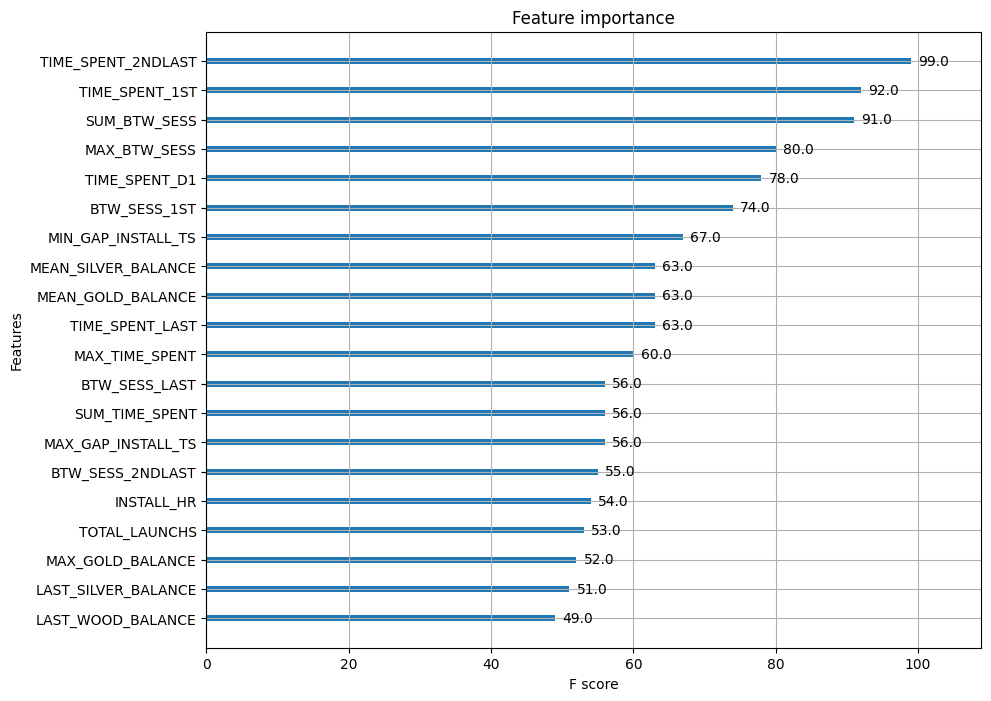

In [12]:
# plt.figure(figsize=(16,10))
xgb.plot_importance(classifier, max_num_features=20)
# plt.legend()
# plt.rcParams["figure.figsize"] = (10, 8)
plt.show()

In [13]:
history = classifier.evals_result()


In [14]:
len(history['validation_0']['auc'])

250

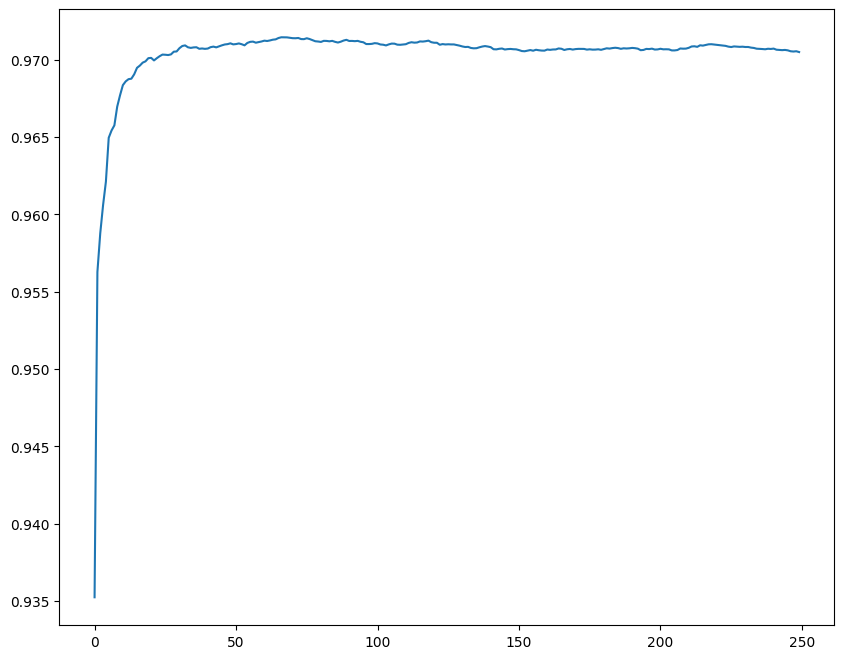

In [15]:
plt.plot(history["validation_0"]["auc"], label="training data")


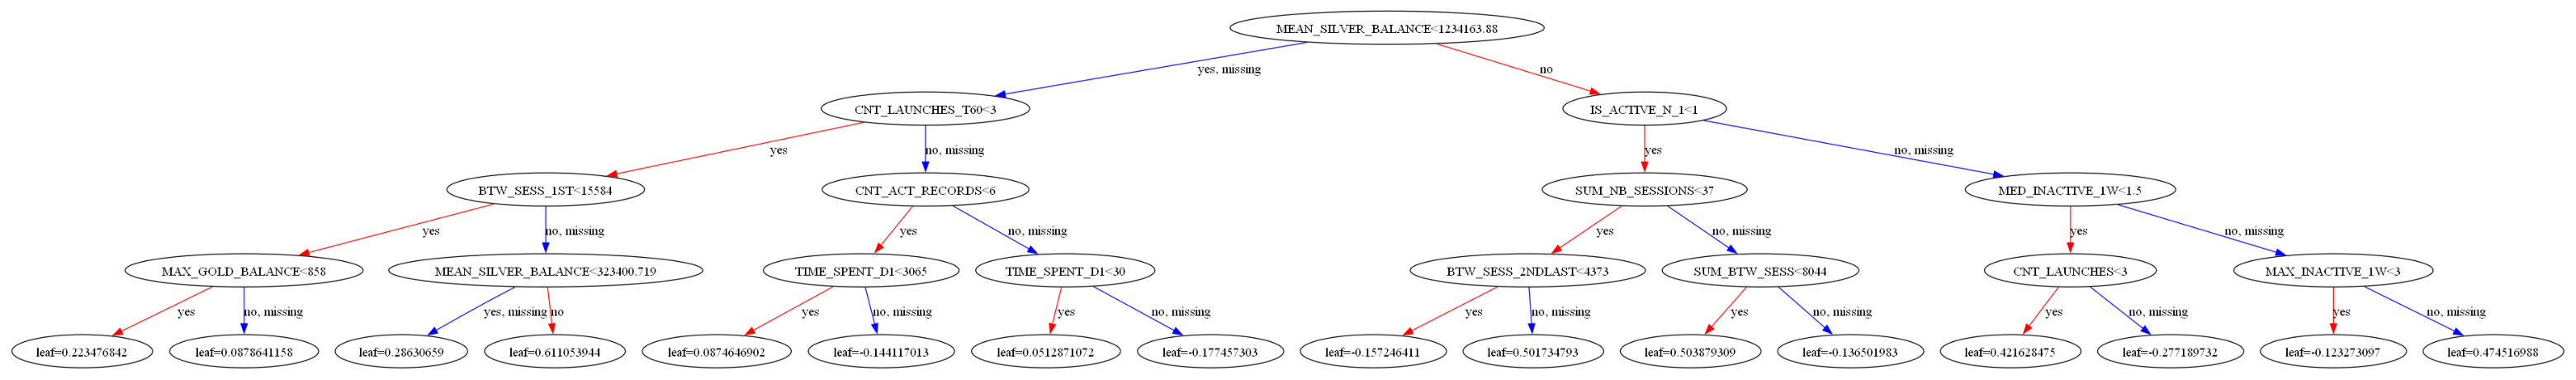

In [35]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (40, 30)
xgb.plot_tree(classifier, num_trees=4)

plt.show()

In [20]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin'
